In [1]:
import json
from pathlib import Path
from PIL import Image as PILImage

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from rhana.labeler.unet import RHEEDTensorImage, RHEEDTensorMask, rle_encode, rle_decode
from rhana.labeler.masker import UnetMasker
from rhana.io.kashiwa import find_raw_rheed
from rhana.pattern import Rheed, RheedMask
from rhana.tracker.iou import IOUTracker, regions2detections, IOUMaskTracker
from rhana.spectrum.spectrum import CollapseSpectrum

In [2]:
rheeds = find_raw_rheed(Path("~/RHEED/data/RHEED").expanduser())

In [3]:
unet_path = "../learner/UNet_May6_2021_fixed.pkl"
masker = UnetMasker(unet_path)

In [4]:
not_processed = [
    "IT020",
    "IT021",
    "IT022",
    "IT023",
    "IT024",
    "IT025",
    "IT027",
    "IT028",
    "IT029",
    "IT030"
]

In [6]:
root = Path("/home/aurora/RHEED/UNetMask_crop")

image = root/"image"
image.mkdir(exist_ok=True)
mask = root/"predicted_mask"
full_mask = root/"predicted_full_mask"
index = root/"index.csv"

offset = 60
window_width = 400
window_height = 200


In [14]:
dbs = []
db_rds = []
db_w = 30
db_h = 30

In [15]:
rheeds.keys()

dict_keys(['IT013', 'IT020', 'IT007', 'IT016', 'IT027', 'IT023', 'IT018', 'IT025', 'IT017', 'IT008', 'IT024', 'IT021', 'IT012', 'IT030', 'IT010', 'IT005', 'IT009', 'IT006', 'IT022', 'IT029', 'IT015', 'IT003', 'IT014', 'IT028', 'IT011'])

In [17]:
for IT in rheeds.keys():
    IT = 'IT009'
# for IT in tqdm(failed, leave=False):
# for IT in tqdm(not_processed, leave=False):
# for IT in tqdm(["IT025"], leave=False):
    if len(rheeds[IT])==0: continue
    is_first = True
    lost_track = False
    
    raw_tracker = IOUMaskTracker(t_min=100000, sigma_iou=0.4)
    detail_tracker = IOUTracker(t_min=2, sigma_iou=0.4)
    
    for i, path in tqdm(enumerate(rheeds[IT]), total=len(rheeds[IT]), leave=False):
        
        # the first part track the direct beam and crop a window below it
        
        # get the mask using UNet
        rd = Rheed.from_kashiwa(path)
#         rd = Rheed.from_kashiwa(path, rotate=-0.7)     # for IT025
        rd = rd.mean_clip().min_max_scale()
        masks = masker.predict(rd)
        rdm_streak = RheedMask(rd, masks['streak'])
        rdm_spot = RheedMask(rd, masks['spot'])
        
        rdm_spot.get_regions(with_intensity=True)
        rdm_spot.filter_regions(min_area=10)

        # track the direct beam using IOU tracker
        region2tracks = raw_tracker.update(regions2detections(rdm_spot.regions), i)
        
        if is_first:
            # run blob detection and region detection in the same time
            # accept if all point to one region
            # pick the one with the biggest mask size if the region the blob point do not agree with the top region 
            db, db_i, track = rdm_spot.get_direct_beam(method="top+tracker", tracker=raw_tracker)
            db_r = rdm_spot.regions[db_i]
            
            rd.get_blobs()
            blob_db, blob_i= rd.get_direct_beam()
            
            blob_r, blob_ri= rdm_spot.get_region_within(x=blob_db[0], y=blob_db[1])
            if blob_ri != db_i and blob_r.area > db_r.area:
                db = blob_db
                db_i = blob_ri
                track = raw_tracker.region2track[blob_ri]
                
            is_first = False
                            
        else:
            try:
                # print("using tracking")
                db, db_i, track = rdm_spot.get_direct_beam(method="tracker", tracker=raw_tracker, track=track)
                if lost_track:
                    print("track is re-initiated by tracking")
                
                lost_track = False
            except KeyError as e:
                if not lost_track:
                    print(f"lost track at {path}")

                lost_track = True
                #
        if lost_track:            
            db_r, db_i = rdm_spot.get_region_within(*db)
            if db_r is not None:
                track = raw_tracker.region2track[db_i]
                print("track is re-initiated by locate a region that contain db point")
                lost_track = False
                
        # crop up a window that is always below the direct beam
        db = (round(db[0]), round(db[1]))
        dbs.append(db)
        db_rds.append(rd.crop(
            sx=db[0]-db_w,
            sy=db[1]-db_h,
            ex=db[0]+db_w,
            ey=db[1]+db_h
        ))
        
        
    break

lost track at /home/aurora/RHEED/data/RHEED/IT009/IT009-00000004585587460500-0070.bin
track is re-initiated by locate a region that contain db point


In [50]:
dbs = np.array(dbs, dtype=int)

In [51]:
len(dbs)

503

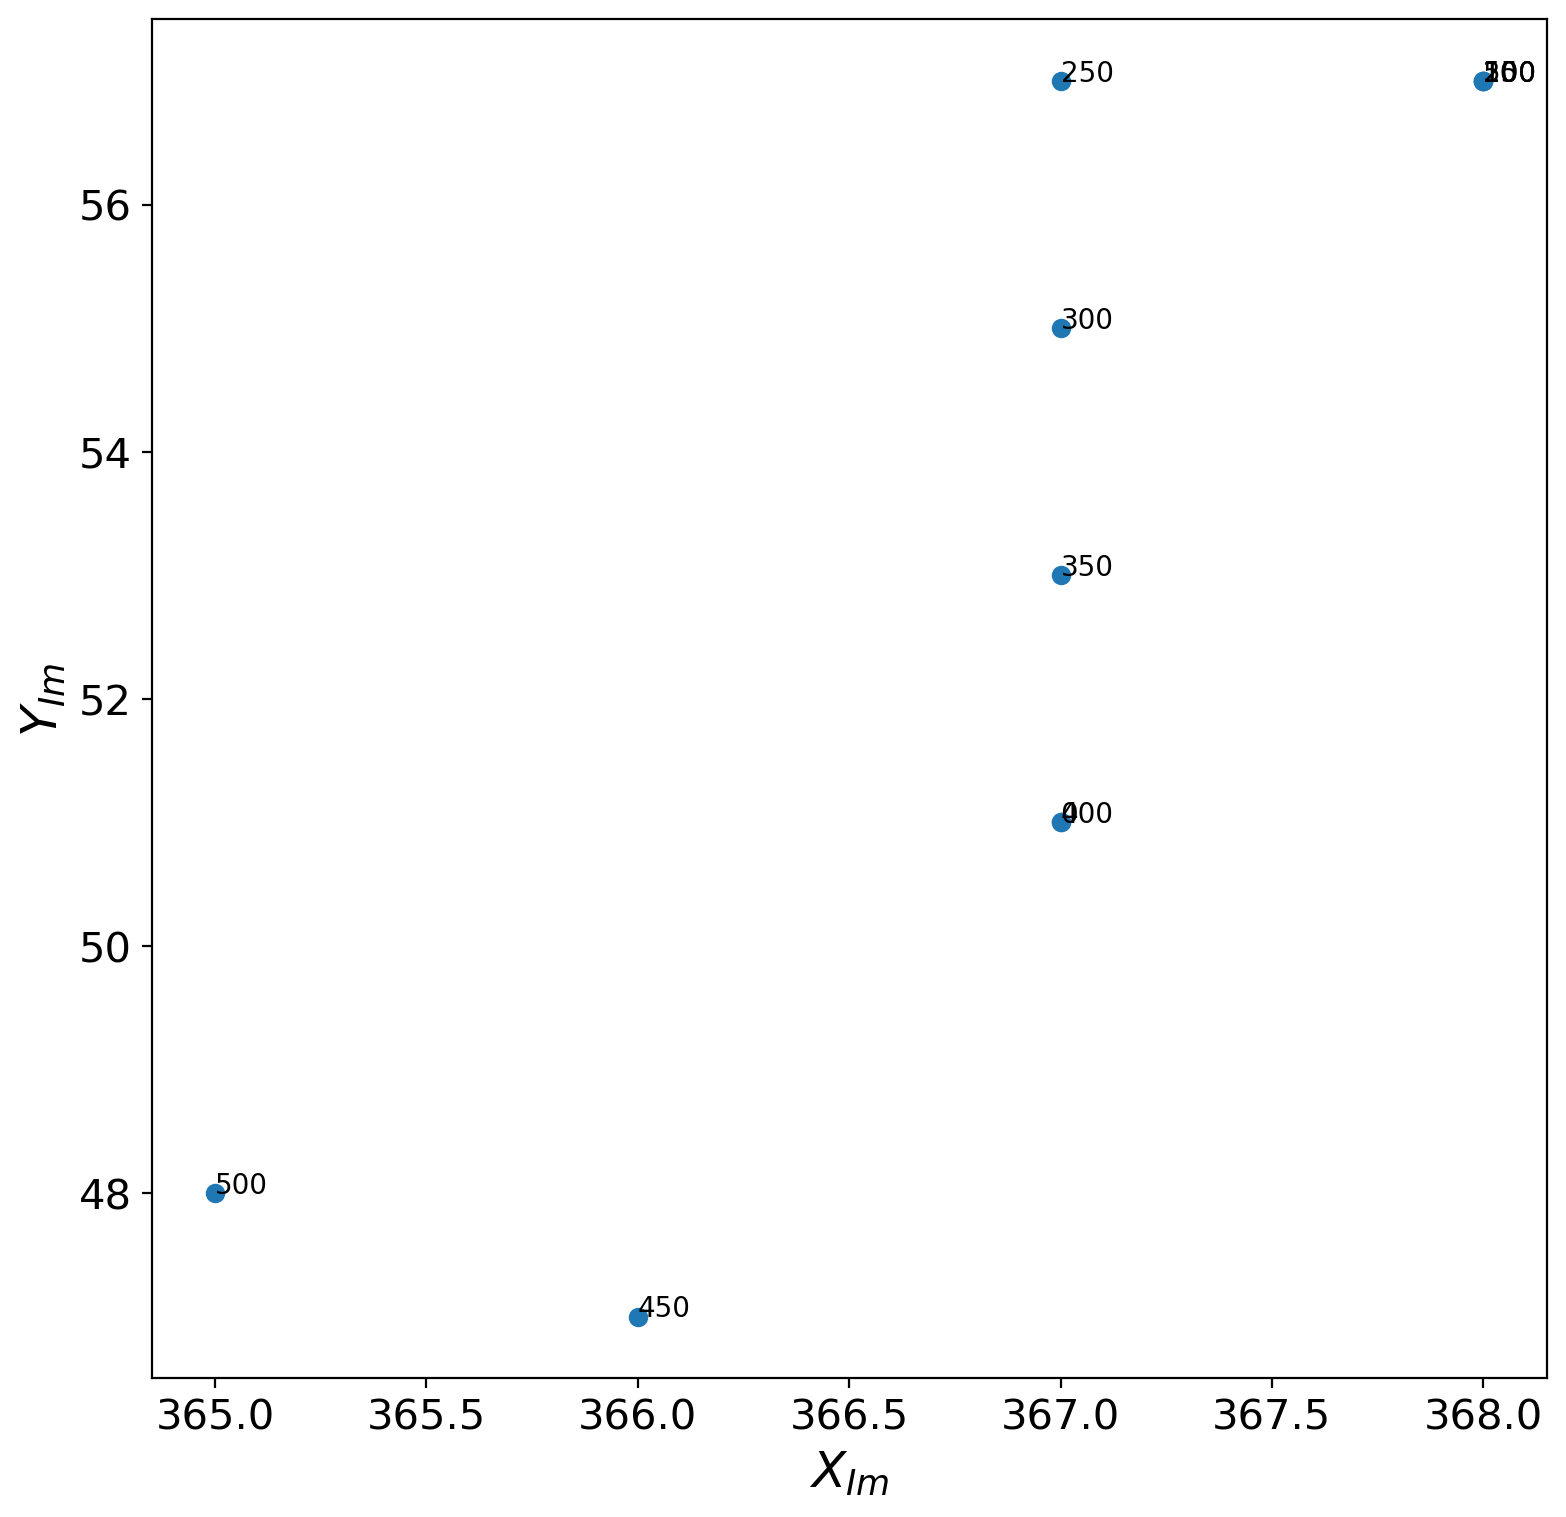

In [52]:
fig, ax = plt.subplots(figsize=(9,9), dpi=200)

selection = np.arange(len(dbs))[::50]
ax.scatter(dbs[selection, 1], dbs[selection, 0])
for s in selection:
    ax.text(dbs[s, 1], dbs[s, 0], s=f"{s}")

center = dbs.mean(axis=0).astype(int)
ax.set_xlabel("$X_{Im}$", fontdict={"size":18})
ax.set_ylabel("$Y_{Im}$", fontdict={"size":18})

ax.tick_params(axis='x', labelsize=15, )
ax.tick_params(axis='y', labelsize=15)

fig.savefig(folder/"main.svg")
fig.savefig(folder/"main.png")

# ax.set_ylim(center[0]-10, center[0]+10)
# ax.set_xlim(center[1]-10, center[1]+10)

In [30]:
rd.plot_pattern??

In [39]:
# cmap = "cividis"
# cmap = "plasma"
# cmap = "viridis"
# cmap = "inferno"
# cmap = "magma"
# cmap = "Greys"
# cmap = "OrRd"
# cmap = "Greens"

folder =  Path(f"publication/db_figure/")
folder.mkdir(exist_ok=True)
selection = np.arange(len(dbs))[::50]

for cmap in ["cividis", "plasma", "viridis", "inferno", "magma", "Greys", "OrRd", "Greens"]:
    for s in selection:
        fig, ax = plt.subplots(dpi=200)
        db = dbs[s]
    #     db_rds[s].plot_pattern(ax, )
        ax.imshow(db_rds[s].pattern, cmap=cmap)
        subfolder = folder / cmap
        subfolder.mkdir(exist_ok=True)
        path = subfolder / Path( f"{s}_{db[0]}_{db[1]}.png")

        plt.axis("off")
        fig.savefig(path)
        plt.close()